(sec_guide_smc)=
# Inferring parameters

This page shows how to infer parameters using the Monte Carlo GAN (iterative Monte Carlo kernel density estimation).
* We'll continue to use the two-parameter
  bottleneck model from the [](sec_guide_creating_a_dinf_model) page.
* Results will be plotted with the `dinf-plot` command.
* Results will be loaded back into Python with via the {func}`dinf.load_results` function.
* Results will be exported as tab-separated values with the `dinf-tabulate` command.

The results below were obtained in under 10 minutes using an 8 core laptop with CPU-only training for the neural network. Note that models with more parameters may need substantially more resources.


## Monte Carlo GAN

Using the `dinf smc` subcommand, we'll do 20 iterations of Monte Carlo simulations,
with 1000 training replicates and 1000 proposal replicates in each iteration.
In each iteration this will
* train the discriminator on 500 samples from the generator
  (with parameter values sampled from the sampling
  distribution) and 500 samples from the target dataset
  (using the `truth` parameter values, as this is a simulation-only model),
* sample 1000 proposals from the generator (with parameter values taken from
  the sampling distribution),
* apply the discriminator on the proposals to obtain predictions about how well they
  match the target dataset,
* approximate the discriminator output as a function of the model parameters,
  using a weighted kernel density estimate of the proposals,
  where the weights are given by the discriminator predictions,
* set the sampling distribution for the next iteration to the approximate distribution
  that was just constructed.

We'll also evaluate the discriminator on 1000 test replicates
(500 from each of the prior distribution and the target dataset).
This test dataset is constructed only once, not in each iteration like
the training or proposal datasets.

In [ ]:
%%bash
mkdir -p out/bottleneck-smc
rm -fr out/bottleneck-smc
time dinf smc \
    --seed 1234 \
    --epochs 5 \
    --iterations 20 \
    --training-replicates 1000 \
    --test-replicates 1000 \
    --proposal-replicates 1000 \
    --model ../../examples/bottleneck/model.py \
    --output-folder out/bottleneck-smc

## The output folder
Once complete, the output folder will contain a sequence of numbered subfolders, one for each iteration.

In [1]:
%%bash
ls out/bottleneck-smc

0
1
10
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9


Inside each of these subfolders is two files: (1) a trained neural network (the `.nn` file), and (2) a data file (the `.npz` file) containing the parameter proposals and their corresponding discriminator predictions.

In [2]:
%%bash
ls out/bottleneck-smc/19

discriminator.nn
smc.npz


## Plotting results

Let's plot the results using `dinf-plot` with the `gan` subcommand. This subcommand produces many figures, including diagnostics and results. Below, we specify an .svg file as the `--output-file`, as this is optimal for viewing in a web browser---note that we only specified one file but many .svg files are produced based on the given filename. When working from the command line, it may be more convenient to specify a .pdf as the output file, which will produce a single multipage pdf file. Alternately, ommitting the `--output-file` option will open each figure in turn in an interactive window.

In [3]:
%%bash
dinf-plot gan \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/bottleneck-smc.svg \
    out/bottleneck-smc

[15:32:41] WARNING  No GPU/TPU found, falling back to CPU.     ]8;id=986514;file:///home/grg/src/dinf/venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=662709;file:///home/grg/src/dinf/venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for                   
                    more info.)                                                 


First, we'll look at the discriminator training metrics in each iteration.

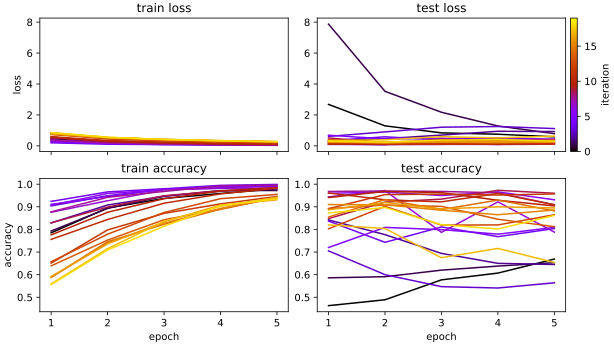

In [4]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/bottleneck-smc_metrics.svg"))

In any given iteration, we see that the training accuracy has increased throughout the 5 training epochs. We also see that the training accuracy declined as the iterations progressed, suggesting that our proposed model parameters have produced data that is increasingly difficult for the discriminator to distinguish from the target dataset. Interestingly, the accuracy on the test dataset increased for the first 10 or so iterations, then began to decrease.

Next, we'll look at the entropy of the discriminator predictions for the proposals, relative to uniformity. This measures how much the sampling distributions are changing from one iteration to the next, where a value of 1.0 indicates no change.

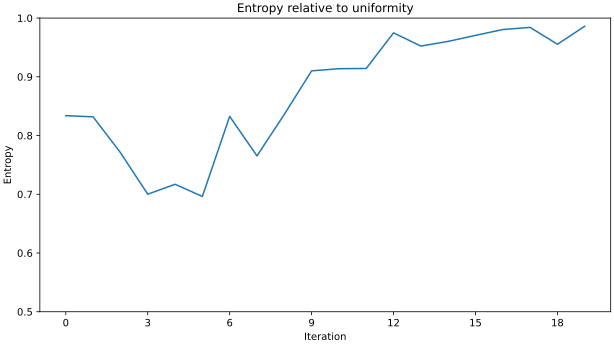

In [5]:
display(SVG(filename="/tmp/bottleneck-smc_entropy.svg"))

From this, we see that after iteration 12, the distributions are not changing much. The changes we observe after this point may just be noise due to resampling.

Another thing we can look at to see how well the GAN is performing is the distribution of discriminator predictions themselves. Recall that the discriminator outputs a value between 0 and 1, with values near 0 meaning the discriminator predicts that the sample came from the generator, and values near 1 being predictions that the sample came from the target dataset. If the discriminator cannot distinguish generated data from the target dataset at all, then it should always guess 0.5. Below are violin plots of the discriminator outputs in each iteration---each blue blob is a kernel density estimate of the discriminator output for that iteration, with dark blue marks indicating the 2.5%, 50%, and 97.5% quantiles.

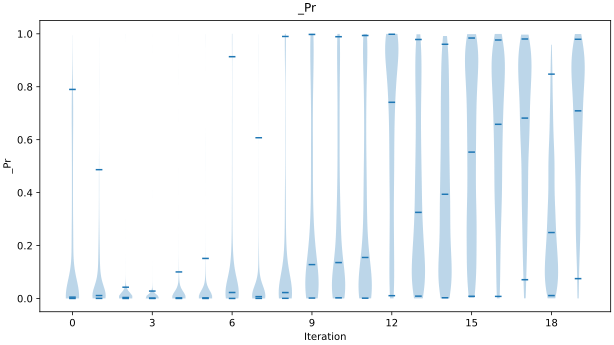

In [6]:
display(SVG(filename="/tmp/bottleneck-smc__Pr.svg"))

In early iterations, we see that most of the discriminator predictions are near 0, but from around iteration 8 onward, the discriminator is making many more non-zero predictions. The discriminator doesn't end up predicting 0.5 for every sample, but this is likely due to bias from training it on a finite (and small) training dataset.

Let's now look at some results. Below are violin plots of the proposals, with one figure produced for each of the parameters (`N0` and `N1` for this model). Recall that the proposals are drawn from the sampling distribution, so these figures show the *marginal* sampling distributions for each iteration.

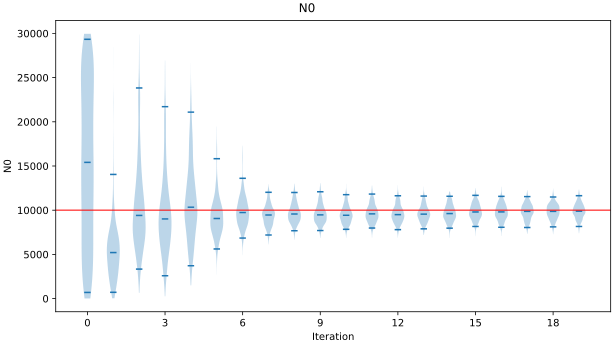

In [7]:
display(SVG(filename="/tmp/bottleneck-smc_N0.svg"))

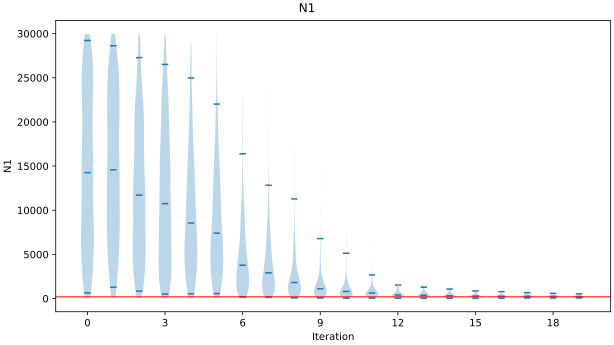

In [8]:
display(SVG(filename="/tmp/bottleneck-smc_N1.svg"))

The sampling distributions for the first iteration reflect the prior distribution, which is uniformly distributed between the upper and lower bounds. Note the reduced density near the parameter bounds, which is an artifact of kernel density estimation. By around iteration 12, the sampling distributions are close to convergence, and they are concentrated around the `truth` values (indicated by the red horizontal lines).

To look more closely at the final marginal sampling distributions, we'll use `dinf-plot` with the `hist` subcommand. We've specified the `--weighted` option here, which will weight the histogram and KDE by the discriminator predictions. Thus, we're plotting the sampling distributions for what will become the hypothetical *next* iteration. These figures show marginal histograms (the dark blue lines), a marginal KDE (the light blue lines), the 2.5%, 50%, and 97.5% quantiles (horizontal black line with whiskers), and the truth value (the vertical red line).

In [9]:
%%bash
dinf-plot hist \
    --weighted \
    --kde \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/bottleneck-smc_hist.svg \
    out/bottleneck-smc/19/smc.npz

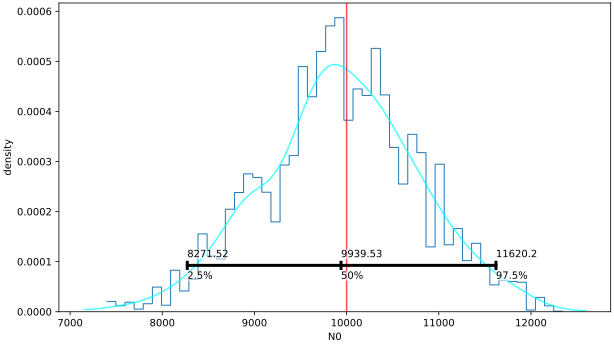

In [10]:
display(SVG(filename="/tmp/bottleneck-smc_hist_N0.svg"))

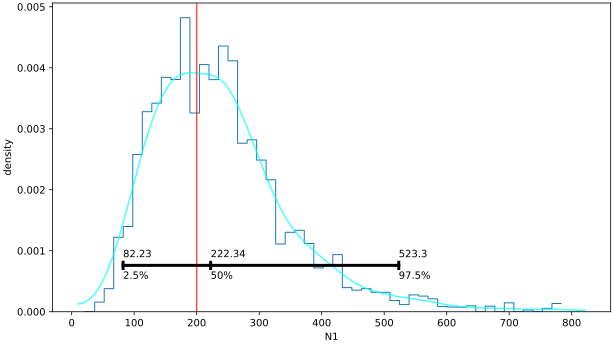

In [11]:
display(SVG(filename="/tmp/bottleneck-smc_hist_N1.svg"))

It looks like the marginal sampling distributions are roughly centered on the truth values, and the 50% quantile (the median) provides a reasonable point estimate for the parameter values.

So far, we've only looked at the marginal distributions---i.e. we've looked at `N0` and `N1` separately. But what about the *joint* sampling distribution of `N0` and `N1`? Do `N0` and `N1` covary? We can visualise two parameters jointly using `dinf-plot` with the `hist2d` subcommand, which produces a 2d histogram. Note that if the model contains more than two parameters, 2d histograms will be plotted for all unique pairs of parameters.

In [12]:
%%bash
dinf-plot hist2d \
    --weighted \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/bottleneck-smc_hist2d.svg \
    out/bottleneck-smc/19/smc.npz

In the 2d histogram below, darker squares indicate a larger density of samples in any given histogram bin. Red lines indicated the truth values for each axis. Note that in two dimensions the data are more sparse than in one dimension, so sampling noise can appear more pronounced.

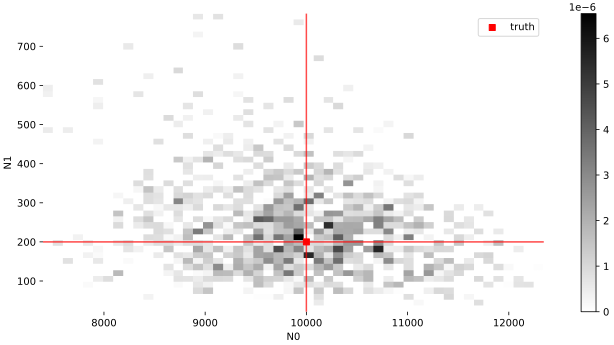

In [13]:
display(SVG(filename="/tmp/bottleneck-smc_hist2d.svg"))

From the 2d histogram, it looks like there might be a small negative correlation between `N0` and `N1` in our sampling distribution. However, we would need to do a proper statistical test to confirm if this is indeed the case.

## Loading results into Python
In some cases, we may wish to load the proposals and/or predictions back into Python for further analysis. The `.npz` file in each subfolder of the output can be loaded back into Python using the {func}`dinf.load_results` function. Below, we'll load the results for the final iteration, to quantify the correlation between `N1` and `N2` that we observed in the 2d histogram.

In [14]:
import dinf
import numpy as np

# Load data as a numpy structured array.
data = dinf.load_results("out/bottleneck-smc/19/smc.npz")
# Calculate the covariance matrix between variables N0 and N1,
# weighted by the discriminator predictions. The predictions
# are in the special data column named '_Pr'.
cov = np.cov(data["N0"], data["N1"], aweights=data["_Pr"])
# Calculate the Pearson correlation coefficient.
r = cov[0,1] / np.sqrt(cov[0,0] * cov[1,1])
r

-0.23658949161983459

This shows that there is a negative correlation between N0 and N1. Let's do 1000 bootstrap replicates over the data to get confidence intervals on the correlation coefficient `r`.

In [15]:
rng = np.random.default_rng(1234)
rs = []
for _ in range(1000):
    # Resample the data, with replacement.
    boot = rng.choice(data, size=len(data))
    # Calculate the (weighted) covariance matrix for this bootstrap replicate.
    cov = np.cov(boot["N0"], boot["N1"], aweights=boot["_Pr"])
    # Calculate the Pearson correlation coefficient.
    r = cov[0,1] / np.sqrt(cov[0,0] * cov[1,1])
    rs.append(r)

# 2.5%, 50%, and 97.5% quantiles.
np.quantile(rs, q=[0.025, 0.5, 0.975])

array([-0.29313046, -0.23542657, -0.17751001])

## Tabulating results
The plots above have all been produced from the files contained in the output folder. But what if we want to copy and paste the numbers that are shown in the plots, or do some further analysis using another programming language such as R? For these reasons, there is a `dinf-tabulate` command which can be used to export information as tab-separated values. We highlight two useful `dinf-tabulate` subcommands below.

First, lets print the `quantiles` of the marginal sampling distributions from the final iteration. The output below reproduces the values shown in the results figures.

In [16]:
%%bash
dinf-tabulate quantiles \
    --weighted \
    out/bottleneck-smc/19/smc.npz

Param	0.025	0.5	0.975
N0	8271.517849092927	9939.527731193346	11620.19949172832
N1	82.2339446503897	222.3362344216462	523.3045728042372


To export the data, we can use `dinf-tabulate` with the `data` subcommand. This outputs tab-separated columns of the proposals and predictions from a given iteration, which can be easily loaded into R using the builtin `read.delim()` function. Below, we'll pipe the output to `head` to look at the first 10 rows of the data. The special column `_Pr` indicates the descriminator prediction, while the other columns (N0 and N1, for the current model) correspond to the parameter values that were sampled for that row's proposal.

In [17]:
%%bash
dinf-tabulate data out/bottleneck-smc/19/smc.npz | head

_Pr	N0	N1
6.693139076232910156e-01	9.904836838507975699e+03	2.540576416713277581e+02
5.270755887031555176e-01	1.048883177066255121e+04	1.313702521022924543e+02
8.349320888519287109e-01	9.756428207835488138e+03	2.176912296627198202e+02
8.926991224288940430e-01	1.027066328428442102e+04	2.714284271946929152e+02
2.640830874443054199e-01	9.609516241364051893e+03	2.538017319184321536e+02
7.795472145080566406e-01	1.064387728001731375e+04	8.232987931949718075e+01
7.977599501609802246e-01	1.029228826017841857e+04	1.441362585085516343e+02
8.896112442016601562e-01	1.083200331833681594e+04	2.460527824468115341e+02
7.925135493278503418e-01	9.426981129653318931e+03	2.185261126100251658e+02
